In [1]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow_text as tf_text

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
dataset_dir = '..\\data'
train_dir = f"{dataset_dir}\\tr"
batch_size = 32
seed = 42

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [5]:
"""FILE_NAMES = ['negativesentences.txt', 'neutralsentences.txt', 'positivesentences.txt']
FILE_NAMES2 = ['negative_valence_sentences.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)
lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\negative_valence_sentences.txt")
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))
labeled_data_sets.append(labeled_dataset)"""

'FILE_NAMES = [\'negativesentences.txt\', \'neutralsentences.txt\', \'positivesentences.txt\']\nFILE_NAMES2 = [\'negative_valence_sentences.txt\']\nlabeled_data_sets = []\n# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.\nfor i, file_name in enumerate(FILE_NAMES):\n    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")\n    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))\n    labeled_data_sets.append(labeled_dataset)\nlines_dataset = tf.data.TextLineDataset(f"{train_dir}\\negative_valence_sentences.txt")\nlabeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))\nlabeled_data_sets.append(labeled_dataset)'

In [6]:
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp0.txt")
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))
labeled_data_sets.append(labeled_dataset)
lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp1.txt")
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 1))
labeled_data_sets.append(labeled_dataset)
lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp2.txt")
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 2))
labeled_data_sets.append(labeled_dataset)

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32
VALIDATION_SIZE = 300
VOCAB_SIZE = 35000

In [8]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [9]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'n\xc3\xa4inh\xc3\xa4n se kannattaa ehdottomasti tehd\xc3\xa4!'
Label: 2
Sentence:  b'ett\xc3\xa4 oli sitten vaikka nettiarvion mukaan t\xc3\xa4ytt\xc3\xa4 tinaa, niin tyytyv\xc3\xa4inen olen!'
Label: 2
Sentence:  b'kyll\xc3\xa4 se h\xc3\xa4t\xc3\xa4 ja puute sek\xc3\xa4 vaihtoehtojen puuttuminen sinutkin miesprostituoidulle ajaisi.'
Label: 0
Sentence:  b'ite oon tota vikaa mua syrjit\xc3\xa4\xc3\xa4n sen takii..'
Label: 0
Sentence:  b'ehk\xc3\xa4 joku sivumotiivi; mutta mit\xc3\xa4 sitten.'
Label: 1
Sentence:  b'itse k\xc3\xa4ytin hepollani tota kun haava kutisi.. '
Label: 0
Sentence:  b'bulgariassa ihmiset roikkuvat h\xc3\xa4nen asuntonsa ikkunoiden takana ottavat kuvia jatkuvasti.'
Label: 1
Sentence:  b'"kreationistille em. evojen luoma "keskustelu"tilanne on l\xc3\xa4hes mahdoton.'
Label: 0
Sentence:  b'perille uuteen jerusalemiin ja tyhm\xc3\xa4t j\xc3\xa4\xc3\xa4v\xc3\xa4t matkalle, kun ei ole valoa y\xc3\xb6ss\xc3\

In [10]:
tokenizer = tf_text.UnicodeScriptTokenizer()

In [11]:
def tokenize(text, unused_label):
    lower_case = tf_text.case_fold_utf8(text)
    return tokenizer.tokenize(lower_case)

tokenized_ds = all_labeled_data.map(tokenize)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [12]:
for text_batch in tokenized_ds.take(5):
    print("Tokens: ", text_batch.numpy())

Tokens:  [b'n\xc3\xa4inh\xc3\xa4n' b'se' b'kannattaa' b'ehdottomasti'
 b'tehd\xc3\xa4' b'!']
Tokens:  [b'ett\xc3\xa4' b'oli' b'sitten' b'vaikka' b'nettiarvion' b'mukaan'
 b't\xc3\xa4ytt\xc3\xa4' b'tinaa' b',' b'niin' b'tyytyv\xc3\xa4inen'
 b'olen' b'!']
Tokens:  [b'kyll\xc3\xa4' b'se' b'h\xc3\xa4t\xc3\xa4' b'ja' b'puute' b'sek\xc3\xa4'
 b'vaihtoehtojen' b'puuttuminen' b'sinutkin' b'miesprostituoidulle'
 b'ajaisi' b'.']
Tokens:  [b'ite' b'oon' b'tota' b'vikaa' b'mua' b'syrjit\xc3\xa4\xc3\xa4n' b'sen'
 b'takii' b'..']
Tokens:  [b'ehk\xc3\xa4' b'joku' b'sivumotiivi' b';' b'mutta' b'mit\xc3\xa4'
 b'sitten' b'.']


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
tokenized_ds = configure_dataset(tokenized_ds)

vocab_dict = collections.defaultdict(lambda: 0)
for toks in tokenized_ds.as_numpy_iterator():
    for tok in toks:
        vocab_dict[tok] += 1

vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
vocab = [token for token, count in vocab]
vocab = vocab[:VOCAB_SIZE]
vocab_size = len(vocab)
print("Vocab size: ", vocab_size)
n = 500
print(f"First {n} vocab entries:", vocab[-50:-1])

Vocab size:  21537
First 500 vocab entries: [b'potkimassa', b'autoliikkeiss\xc3\xa4', b'marssi', b'rynkyn', b'antaminen', b'pohjapalkan', b'oikeuden', b'erehdys', b'asianosaisen', b'vahingoksi', b'soittimessasi', b'ulosanti', b'moiselle', b'sanattomuus', b'ep\xc3\xa4varmuuden', b'tulkintoja', b'tappelee', b'sotii', b'keskenaan', b'tappaen', b'kyl\xc3\xa4\xc3\xa4', b'rakennettiin', b'nykyisen', b'korut', b'paivassa', b'himaan', b'siella', b'liikkeessa', b'postituskuluja', b'jelppas', b'hassutella', b'sy\xc3\xb6tt\xc3\xa4en', b'kutitella', b'lapsellisuuksia', b'syyrialaiset', b'erakkoja', b'hamsteriyhdistyksen', b'nuorekas', b'sporttista', b'kaipaava', b'ostaisi', b'vectran', b'sedanin', b'farkun', b'avensiksen', b'multijulkaiseminen', b'arveluttavaa', b'el\xc3\xa4m\xc3\xa4ll\xc3\xa4', b'tero']


In [15]:
keys = vocab
values = range(2, len(vocab) + 2)  # reserve 0 for padding, 1 for OOV

init = tf.lookup.KeyValueTensorInitializer(
    keys, values, key_dtype=tf.string, value_dtype=tf.int64)

num_oov_buckets = 1
vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)

In [16]:
def preprocess_text(text, label):
    standardized = tf_text.case_fold_utf8(text)
    tokenized = tokenizer.tokenize(standardized)
    vectorized = vocab_table.lookup(tokenized)
    return vectorized, label

In [17]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text, example_label = preprocess_text(example_text, example_label)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'n\xc3\xa4inh\xc3\xa4n se kannattaa ehdottomasti tehd\xc3\xa4!'
Vectorized sentence:  [1529    8  163  816  132   10]


In [18]:
all_encoded_data = all_labeled_data.map(preprocess_text)

train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE)

train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [19]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (32, 21)
Label batch shape:  (32,)
First text example:  tf.Tensor(
[1529    8  163  816  132   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(21,), dtype=int64)
First label example:  tf.Tensor(2, shape=(), dtype=int64)


In [20]:
vocab_size += 2

In [21]:
train_data = configure_dataset(train_data)
validation_data = configure_dataset(validation_data)

In [22]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=True),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.20),
        layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.20),
        layers.Dense(num_labels)
  ])
    return model

In [31]:
model = create_model(vocab_size=vocab_size, num_labels=3)
model.summary()
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(train_data, validation_data=validation_data, callbacks=[early_stop], epochs=15)
model.save('model/first.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1378496   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [32]:
test_loss, test_acc = model.evaluate(validation_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

10/10 [==============================] - 1s 18ms/step - loss: 2.4994 - accuracy: 0.5900
Test Loss: 2.4994375705718994
Test Accuracy: 0.5899999737739563


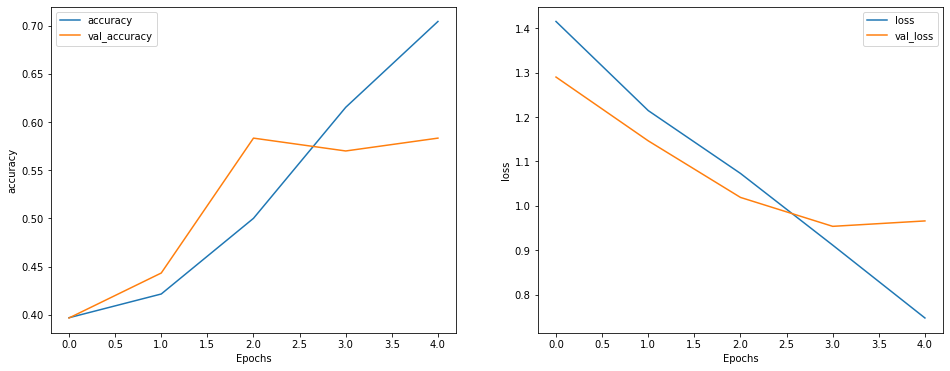

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [26]:
MAX_SEQUENCE_LENGTH = 250
preprocess_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=tf_text.case_fold_utf8,
    split=tokenizer.tokenize,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)
preprocess_layer.set_vocabulary(vocab)

In [27]:
export_model = tf.keras.Sequential(
    [preprocess_layer, model,
     layers.Activation('softmax')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [28]:
# Create a test dataset of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = configure_dataset(test_ds)
loss, accuracy = export_model.evaluate(test_ds)
print("Loss: ", loss)
print(f"Accuracy: {accuracy:2.2%}")

10/10 [==============================] - 16s 38ms/step - loss: 0.9660 - accuracy: 0.5833
Loss:  0.9659698605537415
Accuracy: 58.33%


In [29]:
inputs = [
    "Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.",  # Label: 0
    "Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. ",  # Label: 1
    "Sä oot mulle niin tärkeä ja rakas!"  # Label: 2
]
predicted_scores = export_model.predict(inputs)
print(predicted_scores)
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())

[[0.32506016 0.6733861  0.0015537 ]
 [0.4231966  0.5722146  0.00458878]
 [0.12928739 0.07108957 0.7996231 ]]
Question:  Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.
Predicted label:  1
Question:  Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. 
Predicted label:  1
Question:  Sä oot mulle niin tärkeä ja rakas!
Predicted label:  2


In [30]:
inputs = [
    "Alkaa vituttamaan nuo saatanan rengasmainokset, jotka pomppii koko ajan silmille.", # Label: 0
    "Joka vitun asiassa ne vaan ajattelee seksiä ja haluaa vaan sitä.", # Label: 0
    "Mitä olit niin itserakas, nyt se sitten on mennyt päähäsi!", # Label: 0
    "Huumekuolemat johtuvat lähes poikkeuksetta ylianostuksista ja nekin kovien huumeiden kyseessäollen.", # Label: 1
    "Presidenttihän ei saa edustaa omaa poliittista vakaumustaan.",  # Label: 1
    "Lopulta voi käydä myös niin, että vaikka olettekin olleet yhdessä ja nauttineet keskenänne paljosta rakkaudesta," \
" te ette ole enää oikeita kumppaneita seuraavaa vaihetta varten." # Label: 1
    "Tänäänkin kaipaan kainaloa, hymyäsi ja ennenkaikkea halaustasi pusuista puhumattakaan.",  # Label: 2
    "Saan rakastella ja rakastaa häntä jälleen, Laitan hyvää ruokaa ja hieron hartioita.", # Label: 2
    "Hyvää syksynjatkoa kaikille lukijoilleni ja kiitos kommenteistanne." # Label: 2    
]
predicted_scores = export_model.predict(inputs)
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

Question:  Alkaa vituttamaan nuo saatanan rengasmainokset, jotka pomppii koko ajan silmille.
Predicted label:  1
Question:  Joka vitun asiassa ne vaan ajattelee seksiä ja haluaa vaan sitä.
Predicted label:  1
Question:  Mitä olit niin itserakas, nyt se sitten on mennyt päähäsi!
Predicted label:  0
Question:  Huumekuolemat johtuvat lähes poikkeuksetta ylianostuksista ja nekin kovien huumeiden kyseessäollen.
Predicted label:  0
Question:  Presidenttihän ei saa edustaa omaa poliittista vakaumustaan.
Predicted label:  0
Question:  Lopulta voi käydä myös niin, että vaikka olettekin olleet yhdessä ja nauttineet keskenänne paljosta rakkaudesta, te ette ole enää oikeita kumppaneita seuraavaa vaihetta varten.Tänäänkin kaipaan kainaloa, hymyäsi ja ennenkaikkea halaustasi pusuista puhumattakaan.
Predicted label:  1
Question:  Saan rakastella ja rakastaa häntä jälleen, Laitan hyvää ruokaa ja hieron hartioita.
Predicted label:  2
Question:  Hyvää syksynjatkoa kaikille lukijoilleni ja kiitos komment